# Mixture Density Networks 

a educational reimplementation of otoro's work: [blog_1](https://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/), [blog_2](https://blog.otoro.net/2015/06/14/mixture-density-networks/) & [ipynb](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb)


Mixture Density Networks were brought into the Universe explicitly by [Christopher Bishop](https://www.microsoft.com/en-us/research/people/cmbishop/?from=https%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fum%2Fpeople%2Fcmbishop%2Fdownloads%2FBishop-NCRG-94-004.pdf) in his 1994 Paper- https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/bishop-ncrg-94-004.pdf

<BR>

## Notes
- Direct example of Neural Networks as General Function Approximators
- Application of NNs being able to approximate complex relationships in the data (see the blog_1 post for an interesting contrast between the noisy; sinusoidal and inverse sinusoidal, Mixture of Densities allow us to approximate more complex relationships in data)
  - Mixture of Densities (MOD): Instead of learning a discrete mapping (X --> Y) we instead train our Net to output a probability distribution!
  - Also called/referred to as "Mixture of Gaussians"
- Probability Distribution Function (PDF): is a weighted sum over Gaussian distributions, P(Y=y|X=x) -- the Neural Network predicts the values (means & std devs) of these Gaussians (the probs must sum to one & standard deviations must be positive)
  - The math for which is a bit odd at first but boils down to; sum(softmax(output_values[0:23]) * phi(y, output[24:43], output[44:71])) --> wherein;
    - output_values[indicies]: refer to the indicies of the output of the Network (representing the PDF when put together w above)
- the ipynb on git is the way to view this (torch specific)



In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt 

In [2]:
def generate_data(n_samples):
    epsilon = np.random.normal(size=(n_samples))
    x_data = np.random.uniform(-10.5, 10.5, n_samples)
    y_data = 7*np.sin(0.75*x_data) + 0.5*x_data + epsilon
    return x_data, y_data
    
n_samples = 1000
x_data, y_data = generate_data(n_samples)

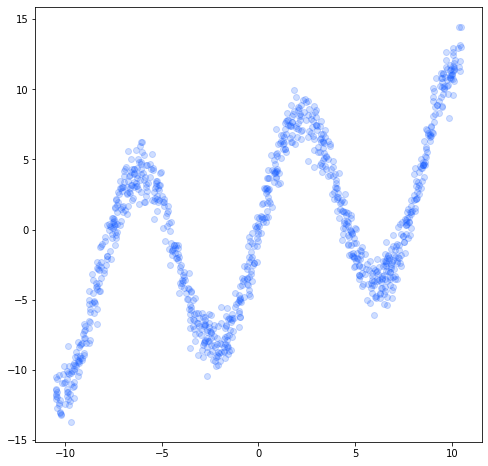

In [9]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.2, color="#135BFF") #FF1376
# plt.axis('off') #remove the axis
plt.show()

In [32]:
# Learn the Above Distribution w a 1-Layer Network


# Define Network Architecture
n_input = 1
n_hidden = 20 #number of hidden nodes
n_output = 1

# create the network (also called a "model" of the data)
network = nn.Sequential(nn.Linear(n_input, n_hidden),
                        nn.Tanh(),
                        nn.Linear(n_hidden, n_output))

# Loss Function (not too bad for the discrete mapper)
loss_fn = nn.MSELoss()

# Optimizer
optimizer = torch.optim.RMSprop(network.parameters())


# Convert Data (Numpy-to-Torch)
# change data type and shape
# note that we need to convert all data to np.float32 for pytorch
x_tensor = torch.from_numpy(np.float32(x_data).reshape(n_samples, n_input))
y_tensor = torch.from_numpy(np.float32(y_data).reshape(n_samples, n_input))
x_variable = Variable(x_tensor)
y_variable = Variable(y_tensor, requires_grad=False)


# Training Loop
def train():
    for epoch in range(3000):
        y_pred = network(x_variable) # make a prediction
        loss = loss_fn(y_pred, y_variable) # compute the loss
        optimizer.zero_grad() # prepare the optimizer
        loss.backward() # compute the contribution of each parameter to the loss
        optimizer.step() # modify the parameters

        if epoch % 300 == 0:
            print(f"Epoch {epoch}    Loss {loss.item()}")

train()

Epoch 0    Loss 38.1699333190918
Epoch 300    Loss 4.766005516052246
Epoch 600    Loss 1.5745048522949219
Epoch 900    Loss 1.1488972902297974
Epoch 1200    Loss 1.113835096359253
Epoch 1500    Loss 1.1005126237869263
Epoch 1800    Loss 1.092761754989624
Epoch 2100    Loss 1.087773323059082
Epoch 2400    Loss 1.0839107036590576
Epoch 2700    Loss 1.0808526277542114


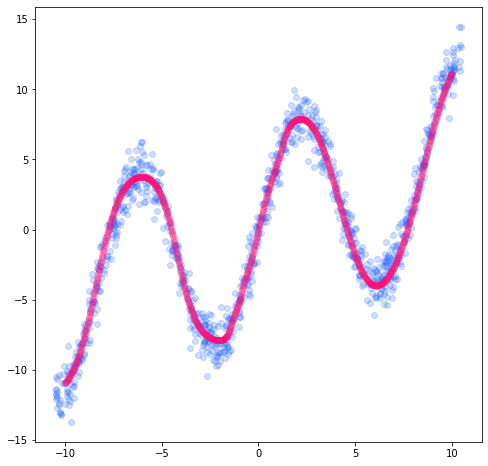

In [33]:
# Create Test Set (evenly spaced samples from -10 to 10, passed through noisy equation)
x_test_data = np.linspace(-10, 10, n_samples) #ground truth

# Torch-to-Numpy (for visualization to play nice)
# change data shape, move from numpy to torch
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(n_samples, n_input))
x_test_variable = Variable(x_test_tensor)
y_test_variable = network(x_test_variable)
y_test_data = y_test_variable.data.numpy() #move preds from test set to Numpy

# Plot the Fit
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.2, color="#135BFF")           #original data
plt.scatter(x_test_data, y_test_data, alpha=0.2, color="#FF1376") #NN generated
plt.show()

Epoch 0    Loss 21.245277404785156
Epoch 300    Loss 21.228595733642578
Epoch 600    Loss 21.213809967041016
Epoch 900    Loss 21.200714111328125
Epoch 1200    Loss 21.189189910888672
Epoch 1500    Loss 21.179101943969727
Epoch 1800    Loss 21.17017936706543
Epoch 2100    Loss 21.16189956665039
Epoch 2400    Loss 21.15353012084961
Epoch 2700    Loss 21.144437789916992


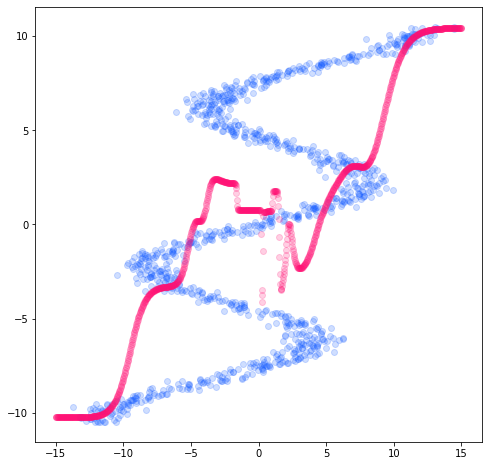

In [35]:
# Invert the Data, give the network a hard time

# # plot x against y instead of y against x -- inverted visualization, redundant with results plot below
# plt.figure(figsize=(8, 8))
# plt.scatter(y_data, x_data, alpha=0.2)
# plt.show()

# Swap the Data
x_variable.data = y_tensor
y_variable.data = x_tensor

train()


# Plot Results
x_test_data = np.linspace(-15, 15, n_samples)
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(n_samples, n_input))
x_test_variable.data = x_test_tensor

y_test_variable = network(x_test_variable)

# move from torch back to numpy
y_test_data = y_test_variable.data.numpy()

# plot the original data and the test data
plt.figure(figsize=(8, 8))
plt.scatter(y_data, x_data, alpha=0.2, color="#135BFF")           #original data
plt.scatter(x_test_data, y_test_data, alpha=0.2, color="#FF1376") #NN generated
plt.show()


In [39]:
# Mixture Density Network Architecture

class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        # Cool components to get probs instead of discrete mapper
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu


# Custom Cost Function -- basically black magic to an idiot like me
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)


# Instantiate Network
network = MDN(n_hidden=20, n_gaussians=5)
optimizer = torch.optim.Adam(network.parameters()) #whip out the bigboy

# Specify Data, may want more samples (for considerably larger output)
mdn_x_data = y_data
mdn_y_data = x_data

mdn_x_tensor = y_tensor
mdn_y_tensor = x_tensor

x_variable = Variable(mdn_x_tensor)
y_variable = Variable(mdn_y_tensor, requires_grad=False)


# New Training Loop (w custom loss function)
def train_mdn():
    for epoch in range(20000):
        pi_variable, sigma_variable, mu_variable = network(x_variable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}    Loss {loss.item():.4f}")

train_mdn() #get good

Epoch 0    Loss 8.1106
Epoch 500    Loss 3.0909
Epoch 1000    Loss 2.9801
Epoch 1500    Loss 2.8062
Epoch 2000    Loss 2.2390
Epoch 2500    Loss 1.7071
Epoch 3000    Loss 1.5996
Epoch 3500    Loss 1.5352
Epoch 4000    Loss 1.4848
Epoch 4500    Loss 1.4527
Epoch 5000    Loss 1.4147
Epoch 5500    Loss 1.3891
Epoch 6000    Loss 1.3753
Epoch 6500    Loss 1.3650
Epoch 7000    Loss 1.3555
Epoch 7500    Loss 1.3448
Epoch 8000    Loss 1.3389
Epoch 8500    Loss 1.3337
Epoch 9000    Loss 1.3307
Epoch 9500    Loss 1.3311
Epoch 10000    Loss 1.3273
Epoch 10500    Loss 1.3220
Epoch 11000    Loss 1.3157
Epoch 11500    Loss 1.3460
Epoch 12000    Loss 1.3205
Epoch 12500    Loss 1.3143
Epoch 13000    Loss 1.3094
Epoch 13500    Loss 1.3042
Epoch 14000    Loss 1.2927
Epoch 14500    Loss 1.2888
Epoch 15000    Loss 1.2855
Epoch 15500    Loss 1.2853
Epoch 16000    Loss 1.2816
Epoch 16500    Loss 1.2795
Epoch 17000    Loss 1.2873
Epoch 17500    Loss 1.2857
Epoch 18000    Loss 1.2846
Epoch 18500    Loss 1.283

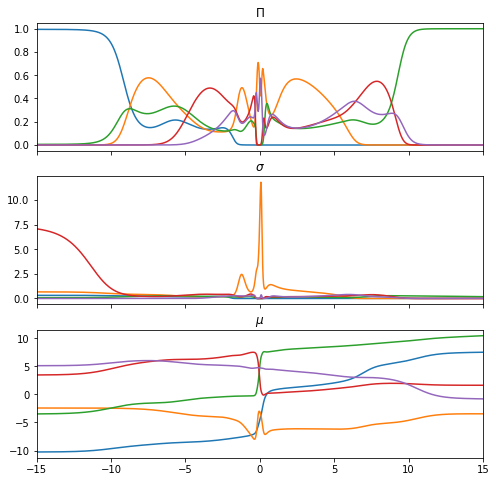

In [40]:
# Look at all those parameters
pi_variable, sigma_variable, mu_variable = network(x_test_variable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test_data, pi_data)
ax1.set_title('$\Pi$')
ax2.plot(x_test_data, sigma_data)
ax2.set_title('$\sigma$')
ax3.plot(x_test_data, mu_data)
ax3.set_title('$\mu$')
plt.xlim([-15,15])
plt.show()

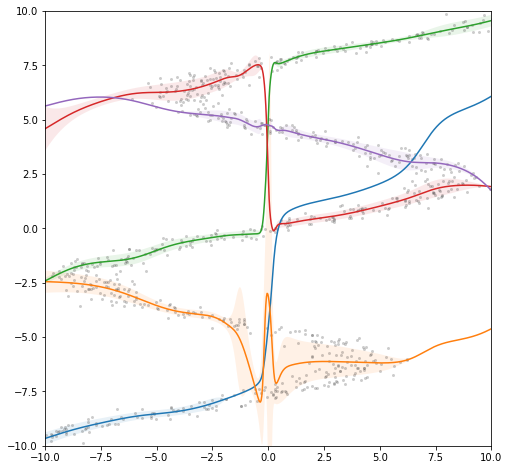

In [41]:
# Plot Individual Gaussians (mu and sigmas)

plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(x_test_data, mu_k)
    plt.fill_between(x_test_data, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(mdn_x_data, mdn_y_data, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

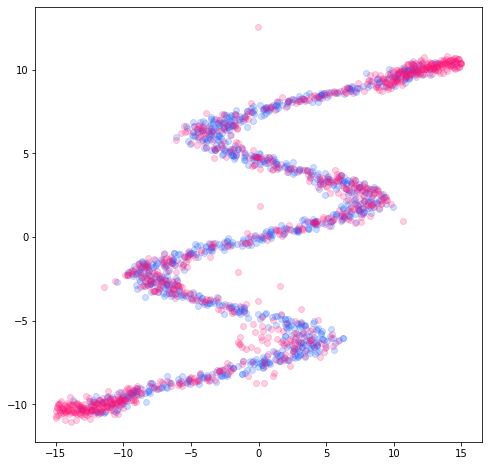

In [43]:
# Black Magic (Gumbel Softmax Sampling- http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/)
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)


# Random Sample other params (mu and sigma)
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]


# Visualize the "fit" of the Data Dist with the MDN
plt.figure(figsize=(8, 8))
plt.scatter(mdn_x_data, mdn_y_data, alpha=0.2, color="#135BFF") #original data
plt.scatter(x_test_data, sampled, alpha=0.2, color="#FF1376")   #NN generated
plt.show()